# Przewidywanie kursu dolara przy pomocy rekurencyjnej sieci neuronowej

<p>Ten projekt nie skupia się na utworzeniu jak najdokładniejszego modelu do predykcji, a do demonstracji procesu wykonania takiego modelu:</p>
<ul>
    <li>Akwizycja danych</li>
    <li>Analiza danych i ich przygotowanie do treningu</li>
    <li>Utworzenie architektury modelu i jego trening</li>
    <li>Zapisanie i użycie utworzonego modelu</li>
</ul>

## 1)Akwizycja danych - scraping aktualnych danych ze strony biznesradar.pl

<p>Używam biblioteki Scrapy do uzyskania danych ze strony <a href="https://www.biznesradar.pl">biznesradar.pl</a><br>
   W skrypcie można podać adres źródłowy, a więc jaki kurs chcemy zescrapować, oraz maksymalną ilość stron, które chcemy przejrzeć.
    <br>
   Wynik jest zapisany do pliku "kurs.csv"
</p>

In [ ]:
from scrapy.crawler import CrawlerProcess
from StockMarketSpider import StockMarketSpider

SOURCE_URL = 'https://www.biznesradar.pl/notowania-historyczne/USDPLN'
NAME = "biznesradar-spider"
MAX_PAGES = 30

process = CrawlerProcess(
    settings={
        "FEEDS": {
            "kurs.csv": {"format": "csv"},
        },
    }
)

process.crawl(StockMarketSpider, source_url=SOURCE_URL, name=NAME, max_pages=MAX_PAGES)
process.start()  # the script will block here until the crawling is finished

## Analiza i przygotowanie danych

<p>Wczytanie do obiektu dataframe i podgląd:</p>

In [2]:
import pandas as pd

df = pd.read_csv('kurs.csv')
print( df.head() )
print( df.tail() )

         Data  Otwarcie     Max     Min  Zamknięcie
0  28.03.2025    3.8768  3.8862  3.8542      3.8610
1  27.03.2025    3.8964  3.8986  3.8681      3.8767
2  26.03.2025    3.8607  3.8994  3.8561      3.8966
3  25.03.2025    3.8655  3.8713  3.8437      3.8606
4  24.03.2025    3.8731  3.8790  3.8520      3.8654
            Data  Otwarcie     Max     Min  Zamknięcie
1495  28.06.2019    3.7370  3.7411  3.7270      3.7274
1496  27.06.2019    3.7435  3.7524  3.7360      3.7370
1497  26.06.2019    3.7416  3.7548  3.7382      3.7437
1498  25.06.2019    3.7281  3.7500  3.7245      3.7414
1499  24.06.2019    3.7348  3.7412  3.7280      3.7282


<p>Definicja funkcji pozwalającej wybrać przedział czasu i wybór cen z danego przedziału czasowego</p>

In [3]:
from datetime import datetime as dt
def selectTimeRange(df, start_date, end_date, date_col):
    
    low_idx = 0
    while ( dt.strptime( df[date_col][low_idx], '%d.%m.%Y') >= dt.strptime( end_date, '%d.%m.%Y') ) and (low_idx<len(df)-1):
        low_idx = low_idx + 1
    
    up_idx = len(df)-1
    while ( dt.strptime( df[date_col][up_idx], '%d.%m.%Y') <= dt.strptime( start_date, '%d.%m.%Y') ) and (up_idx>0):
        up_idx = up_idx - 1
        
    df = df[ low_idx:up_idx ]
    df.reindex( [ i for i in range(len(df)) ] )
    return df 

In [4]:
from datetime import datetime

START_DATE = '01.01.2020'
END_DATE = datetime.today().strftime('%d.%m.%Y') # dzisiaj
DATE_COL='Data'
df = selectTimeRange(df, START_DATE, END_DATE, date_col=DATE_COL)

In [5]:
print(df.tail())

            Data  Otwarcie     Max     Min  Zamknięcie
1357  09.01.2020    3.8076  3.8251  3.8052      3.8198
1358  08.01.2020    3.8064  3.8180  3.7986      3.8077
1359  07.01.2020    3.7779  3.8094  3.7775      3.8064
1360  06.01.2020    3.8001  3.8056  3.7773      3.7778
1361  03.01.2020    3.7922  3.8246  3.7897      3.7980


<p>Wybranie tylko ceny w momencie zamknięcia i narysowanie wykresu:</p>

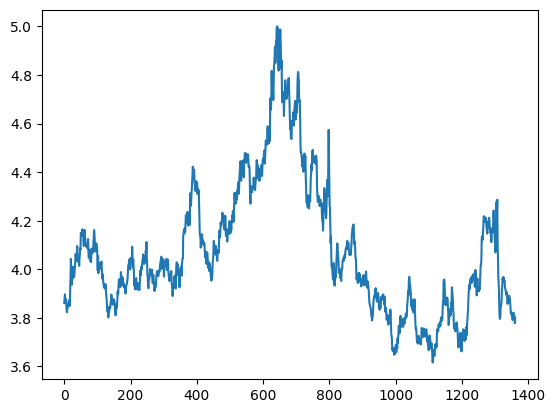

In [21]:
from matplotlib import pyplot as plt

df = df['Zamknięcie']
plt.plot( df )

<p>Usunięcie elementów nietypowych na podstawie względnej zmiany ceny między zamknięciami</p>

In [7]:
# def relativeChange( prizes ):
#     result = [None]*( len(prizes) )
#     result[0] = 0
#     for i in range( 1, len(prizes) ):
#         result[i] = prizes[i] / prizes[i-1]
#     return result
def relativeAbsoluteChange( prizes ):
    result = [None]*( len(prizes) )
    result[0] = 0
    for i in range( 1, len(prizes) ):
        result[i] = prizes[i] / prizes[i-1] - 1
    return result

In [8]:
dt = relativeAbsoluteChange(df)

In [9]:
def kernelEstimation(values, method='gaussian', percentile=7):
    from sklearn.neighbors import KernelDensity
    import numpy as np

    values = np.array(values)
    values = values.reshape(-1, 1)
    kde = KernelDensity(kernel=method).fit(values)
    yvals = kde.score_samples(values) 
    outlier_inds = np.where(yvals < np.percentile(yvals, percentile))[0]
    return [ [i, values[i] ] for i in outlier_inds ]

Text(0.7, 0.8, 'Czerwone wartości zostały usunięte')

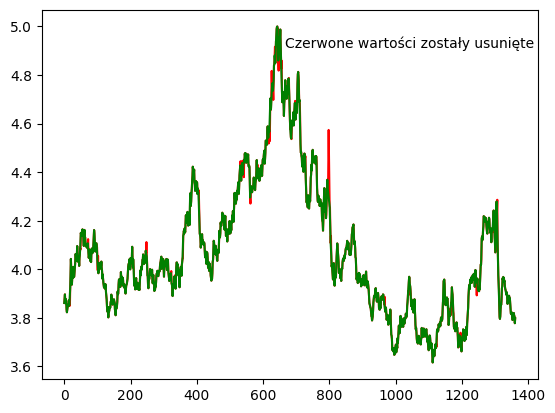

In [10]:
outliers = kernelEstimation(dt[1:])
outlier_indices = [o[0] for o in outliers]

df_cleaned = df[ df.index.isin(outlier_indices) == False ]

df_dt = pd.DataFrame(dt, columns=['zmiana'])
df_dt_cleaned = df_dt[ df_dt.index.isin(outlier_indices) == False ]

plt.plot(df,'r', df_cleaned,'g')
plt.figtext(0.7, 0.8, 'Czerwone wartości zostały usunięte', ha='center')

<p>Przygotowanie danych do treningu.<br>
   Sieć LSTM lepiej radzi sobie z wartościami zmian niż z cenami.
</p>

In [11]:
# Odłożenie części danych do późniejszej predykcji
future_len = 100

# Funkcja zależna od rodzju danych!!!
def prepareData(raw_data):
    x_cols = ['zmiana']
    y_cols = ['zmiana']
    X=[None]*( len(raw_data) - 1 )
    y=[None]*( len(raw_data)  - 1 )
    
    
    for i in range( len(raw_data)-1):
        xvals = []
        for col in x_cols:
            xvals.append( raw_data[col].iloc[i] )
        X[i] = xvals
        
        yvals = []
        for col in y_cols:
            yvals.append( raw_data[col].iloc[i + 1] )
        y[i] = yvals
    
    
    return {'X':X, 'y':y}

processed_data = prepareData(df_dt_cleaned[1:-future_len])
trainingProportion=0.7

def splitDataToTrainAndTest( processed_data, trainingProportion):
    # trainingPorportion - stosunek podziału danych treningowych do testowych (0;1) 
    
    data_len = len(processed_data['X'])
    
    X_train = processed_data['X'][:int(data_len*trainingProportion)]
    y_train = processed_data['y'][:int(data_len*trainingProportion)]
    X_val = processed_data['X'][int(data_len*trainingProportion):]
    y_val = processed_data['y'][int(data_len*trainingProportion):]
    
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = splitDataToTrainAndTest(processed_data,trainingProportion )

import numpy as np

# TODO - poprawić to
X_train = np.array([[x[0] for x in X_train]])
y_train = np.array([[x[0] for x in y_train]])
X_val = np.array([[x[0] for x in X_val]])
y_val = np.array([[x[0] for x in y_val]])

## Utworzenie modelu - definicja architektury i trening

<p>Tworzę prosty model sekwencyjny LSTM z użyciem biblioteki Tensorflow</p>

In [19]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 

n_input = 1
n_features = 1

model_stock = Sequential()

model_stock.add(InputLayer((n_input, n_features)))

model_stock.add(LSTM(300, return_sequences=True))
model_stock.add(Dropout(0.2))

# model_stock.add(Flatten())
model_stock.add(Dense(1, activation="linear"))

model_stock.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 300)         │       362,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 1)           │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 362,701 (1.38 MB)

 Trainable params: 362,701 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3 )
model_stock.compile(loss = MeanSquaredError(),
    optimizer='adam',
    metrics=['accuracy']),
history = model_stock.fit(
    X_train, y_train,
    validation_data= (X_val, y_val),
    epochs = 100,
    callbacks=[early_stop],
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 4.7693e-05 - val_accuracy: 0.0000e+00 - val_loss: 1.0160e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.0000e+00 - loss: 1.1483e-04 - val_accuracy: 0.0000e+00 - val_loss: 1.3765e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.0000e+00 - loss: 1.5064e-04 - val_accuracy: 0.0000e+00 - val_loss: 7.7452e-05
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.0000e+00 - loss: 9.0083e-05 - val_accuracy: 0.0000e+00 - val_loss: 3.6588e-05
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0000e+00 - loss: 5.0294e-05 - val_accuracy: 0.0000e+00 - val_loss: 7.3349e-05
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.0000e+00 - loss: 8.7306e-05 - val_accuracy: 0.0000e+00 - val_loss: 7.1311e-05
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0000e+00 - loss: 8.5011e-05 - val_accuracy: 0.0000e+00 - val_loss: 4.2098e-05


<Axes: >

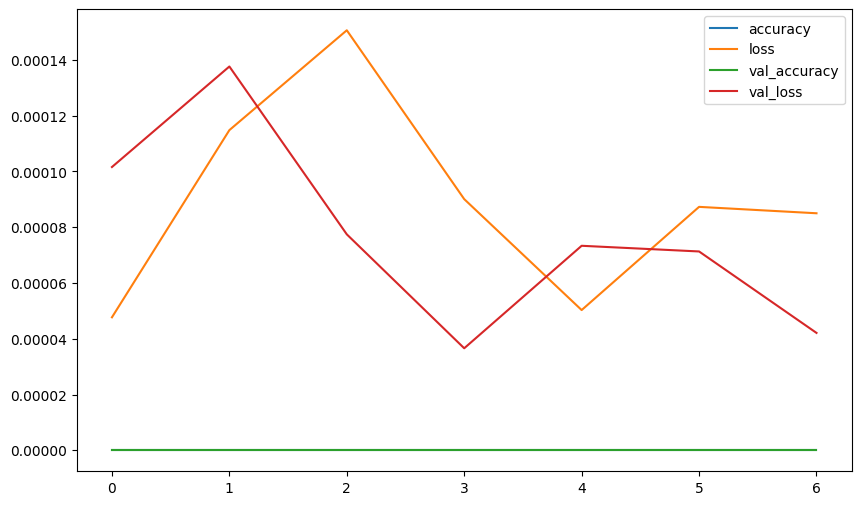

In [14]:
import pandas as pd

losses_df = pd.DataFrame(model_stock.history.history)
losses_df.plot(figsize = (10,6))

## Zapisanie i użycie utworzonego modelu

<p>Zapisuję model używając metody klasowej:</p>

In [15]:
model_stock.save('stock_price_predictor.keras')

<p>Wczytywanie zapisanego modelu:</p>

In [16]:
model_stock = tf.keras.models.load_model('stock_price_predictor.keras')

<p>Predykcja na danych treningowych i walidacyjnych:</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


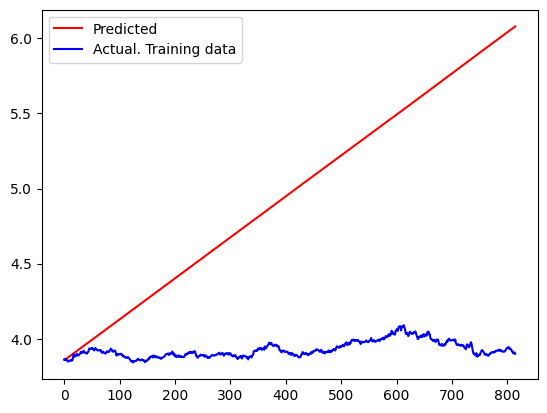

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


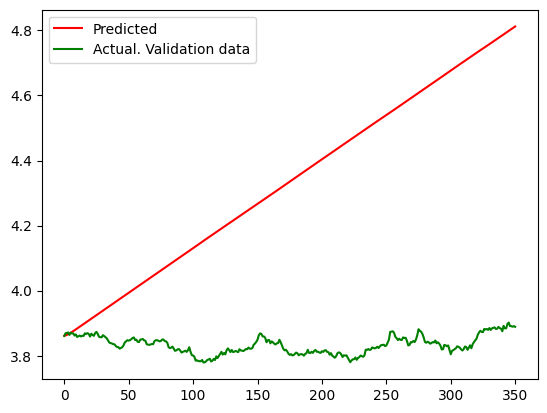

In [17]:
def integral(X, initial_state):
    result = [None]*(len(X)+1)
    result[0] = initial_state
    for i in range(1, len(result)):
        result[i] = result[i-1] + (lambda x: x[0] if type(x) == list else x )(X[i-1])
    return result

def integral2(X, initial_state):
    result = [None]*(len(X)+1)
    result[0] = initial_state
    for i in range(1, len(result)):
        result[i] = result[i-1] + (lambda x: x[0] if type(x) == list else x )(X[i-1]) * 4
    return result

initial_state = df_cleaned[0]

from matplotlib import pyplot as plt

# predykcja - tylko training data
X_test = X_train
y_pred = model_stock.predict(X_test).flatten()
plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
plt.plot( integral(y_train[0], initial_state), 'b', label="Actual. Training data")
plt.legend()
plt.show()

# predykcja - tylko validation data
X_test = X_val
y_pred = model_stock.predict(X_test).flatten()
plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
plt.plot( integral( y_val[0], initial_state ), 'g', label="Actual. Validation data")
plt.legend()
plt.show()

<p>Predykcja na nieznanych danych</p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


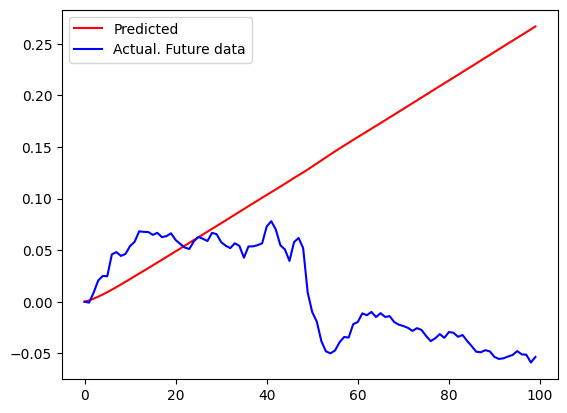

In [18]:
# predykcja - odłożona wcześniej porcja danych
future_data = prepareData(df_dt_cleaned[-future_len:])
f_training_proportion = 1
X_future, y_future, _, _ = splitDataToTrainAndTest(future_data, f_training_proportion)
X_future = np.array([[x[0] for x in X_future]])
y_future = np.array([[x[0] for x in y_future]])


y_pred = model_stock.predict(X_future).flatten()
initial_state = 0

plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
plt.plot( integral(y_future[0], initial_state), 'b', label="Actual. Future data")
plt.legend()
plt.show()